# Fine-tuning the BERT model for Tip Mining
Combination of Huggingface library and TensorFlow 
 --------------------------------------
@author: Erik van der Heide, EUR 2021-2022

In [ ]:
!nvidia-smi

Wed Jun 23 07:30:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Hyperparameters

In [ ]:
# Hyperparameters
data_type = 'fullf'        # Choose data 'subsetX' or 'full'
model_type = 'distilbert'  # Choose model 'bert', 'distilbert' or 'roberta'
optim_type = 'adam'        # Choose optimizer 'Adam' or 'AdamW'
use_weights = False         # True when using class weights for unbalanced data, False ow
max_seq_length = 64        # define maximum length (32, 64)
train_batch_size = 16      # define batch size (16, 32)
learning_rate = 2e-5       # define learning rate (2e-5, 3e-5, 5e-5)
num_epochs = 2             # define nr. of epoch (1, 2, 3, 4)

### Installations & packages

In [ ]:
# Install transformers
!pip install transformers

     |████████████████████████████████| 2.5MB 5.5MB/s 
     |████████████████████████████████| 3.3MB 23.5MB/s 
     |████████████████████████████████| 901kB 37.7MB/s 


In [ ]:
# Install tensorflow model environment
#!pip install -q tf-models-official

In [ ]:
# Packages
import pandas as pd
import time
import random

import torch
import torch.nn as nn
import tensorflow as tf
#from official.nlp import optimization

from transformers import BertTokenizerFast, DistilBertTokenizerFast, RobertaTokenizerFast
from transformers import TFDistilBertForSequenceClassification
from transformers import TFBertForSequenceClassification
from transformers import TFRobertaForSequenceClassification

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.metrics import confusion_matrix

### Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data for debugging
if data_type=='subset' : path ="drive/MyDrive/Thesis BA&QM 2021/Data/td_clean_subset.csv"
if data_type=='subsetf': path ="drive/MyDrive/Thesis BA&QM 2021/Data/td_clean_subset_filtered.csv" 
if data_type=='full'   : path ="drive/MyDrive/Thesis BA&QM 2021/Data/td_clean.csv"    
if data_type=='fullf'  : path ="drive/MyDrive/Thesis BA&QM 2021/Data/td_clean_full_filtered.csv"   

# Data for running
if data_type=='subset1': path ="drive/MyDrive/Thesis BA&QM 2021/Data/td_clean_subset1.csv"
if data_type=='subset2': path ="drive/MyDrive/Thesis BA&QM 2021/Data/td_clean_subset2.csv"
if data_type=='subset3': path ="drive/MyDrive/Thesis BA&QM 2021/Data/td_clean_subset3.csv"
if data_type=='subset4': path ="drive/MyDrive/Thesis BA&QM 2021/Data/td_clean_subset4.csv"
if data_type=='subset5': path ="drive/MyDrive/Thesis BA&QM 2021/Data/td_clean_subset5.csv"

# Data for categories (5050 manually)
if data_type=='baby'  : path ="drive/MyDrive/Thesis BA&QM 2021/Data/td_clean_baby5050.csv"
if data_type=='music' : path ="drive/MyDrive/Thesis BA&QM 2021/Data/td_clean_music5050.csv"
if data_type=='sports': path ="drive/MyDrive/Thesis BA&QM 2021/Data/td_clean_sports5050.csv"
if data_type=='tools' : path ="drive/MyDrive/Thesis BA&QM 2021/Data/td_clean_tools5050.csv"
if data_type=='toys'  : path ="drive/MyDrive/Thesis BA&QM 2021/Data/td_clean_toys5050.csv"
if data_type=='random': path ="drive/MyDrive/Thesis BA&QM 2021/Data/td_clean_random5050.csv"

# Read in data
df = pd.read_csv(path, sep="\t", header=0)
print(path)

drive/MyDrive/Thesis BA&QM 2021/Data/td_clean_full_filtered.csv


In [ ]:
# Choose which data you want to use
df = df[['sentence', 'tip']]
df.reset_index(drop=True, inplace=True)
df['tip'] = df['tip'].astype(int)
print(f"Tip distribution:\n{df['tip'].value_counts(normalize=True)}")
df.dtypes

Tip distribution:
0    0.945627
1    0.054373
Name: tip, dtype: float64


sentence    object
tip          int64
dtype: object

We split the data into 65% training, 15% validation and 20% testing.

In [ ]:
if data_type[-1] in ['0','1','2','3','4','5','6','7','8','9']: 
  rand_state = int(data_type[-1]) 
else:
  rand_state = 0
print(f"Random state: {rand_state} \n")

# Train+validation and test split
X_train, X_test, y_train, y_test = train_test_split(df['sentence'], df['tip'], random_state=rand_state,  train_size=0.8, stratify=df['tip'])

# Train and validation split
#X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=0, train_size = 0.65/0.8, stratify=y_trainval)

# Reset indices
#X_train.reset_index(drop=True, inplace=True), y_train.reset_index(drop=True, inplace=True)
#X_val.reset_index(drop=True, inplace=True), y_val.reset_index(drop=True, inplace=True)
#X_test.reset_index(drop=True, inplace=True), y_test.reset_index(drop=True, inplace=True)

# Sizes & example:
print(f"Train size : {X_train.size} - {100*round(X_train.size/df.shape[0], 2)}% - ratio {round(y_train.value_counts(normalize=True)[0],2)}-{round(y_train.value_counts(normalize=True)[1],2)}")
#print(f"Valid size : {X_val.size} - {100*round(X_val.size/df.shape[0], 2)}% - ratio {round(y_val.value_counts(normalize=True)[0],2)}-{round(y_val.value_counts(normalize=True)[1],2)}") 
print(f"Test size  : {X_test.size} - {100*round(X_test.size/df.shape[0], 2)}% - ratio {round(y_test.value_counts(normalize=True)[0],2)}-{round(y_test.value_counts(normalize=True)[1],2)}") 
#print(f"\nExample train data: X = '{X_train[0]}'  y = {y_train[0]}")

Random state: 0 

Train size : 49628 - 80.0% - ratio 0.95-0.05
Test size  : 12407 - 20.0% - ratio 0.95-0.05


### Tokenization

Choose a tokenizer corresponding to your model of choice.

In [ ]:
if model_type.lower() == 'distilbert':
  tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
elif model_type.lower() == 'bert':
  tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
elif model_type.lower() == 'roberta':
  tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
tokenizer

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

Tokenize the training, validation and test set.

In [ ]:
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=max_seq_length)
#val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True, max_length=max_seq_length)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=max_seq_length)

# Example
#print(f"Example        : {X_train[0]}")
#toks = ['CLS'] + tokenizer.tokenize(X_train[0]) + ['SEP']
#print(f"Tokens         : {toks}  ({len(toks)} tokens)")
#print(f"Token id's     : {train_encodings['input_ids'][0]}")
#print(f"Attention mask : {train_encodings['attention_mask'][0]}")

In [ ]:
#with tf.device('/cpu:0'): # run on cpu
# Write datasets to tensor slices
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
#val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test))

### Model definition

Set the model to your prefered model architecture.

In [ ]:
if model_type.lower() == 'distilbert':
  model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
elif model_type.lower() == 'bert':
  model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
elif model_type.lower() == 'roberta':
  model = TFRobertaForSequenceClassification.from_pretrained('roberta-base')
model

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

Define your optimizer, loss function, and evaluation metrics, then compile the model.

In [ ]:
# Optimizer
if optim_type.lower() == 'adam':
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif optim_type.lower() == 'adamw':  # not improving results
  steps_per_epoch = 156
  num_train_steps = steps_per_epoch * num_epochs
  num_warmup_steps = int(0.1*num_train_steps)
  optimizer = optimization.create_optimizer(init_lr=learning_rate,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')
  
# Loss function
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
# Sparse, as true are [0, 1, ..], and pred is [[0.9, 0.1], [0.2, 0.8]]

# Evaluation metrics
ev_metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

# Compile model  
model.compile(optimizer=optimizer, loss=loss_function, metrics=ev_metrics)

# Save weights of model with minimum validation loss
#checkpoint_filepath = '/content/drive/MyDrive/Thesis BA&QM 2021'
#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#    filepath=checkpoint_filepath,
#    save_weights_only=True,
#    monitor='val_loss',
#    mode='min',
#    save_best_only=True)

In [ ]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  1538      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


Run the model.

In [ ]:
from sklearn.utils import class_weight 
import numpy as np
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict(enumerate(class_weights))
print("Class weights: ", class_weights)

Class weights:  {0: 0.5287449392712551, 1: 9.19718309859155}


In [ ]:
train_data = train_dataset.shuffle(1000).batch(train_batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
#valid_data = val_dataset.batch(train_batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
test_data = test_dataset.batch(train_batch_size, drop_remainder=False).prefetch(tf.data.experimental.AUTOTUNE)

start = time.time()

# Fit model
if use_weights == True:
  history = model.fit(train_data, 
       #   validation_data=valid_data, 
          epochs=num_epochs,
         #callbacks=[model_checkpoint_callback],
          verbose=1,
          class_weight = class_weights)
else: 
  history = model.fit(train_data, 
        #  validation_data=valid_data, 
          epochs=num_epochs,
          #callbacks=[model_checkpoint_callback],
          verbose=1)

end = time.time()
print("Training completed")
print("Elapsed time fine-tuning the model: ", (end-start)/60, "min\n")

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

### Evaluate epochs

Print the train and validation loss given the epoch number.

In [ ]:
if num_epochs > 1:
  history_dict = history.history
  #print(history_dict.keys())

  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)
  fig = plt.figure(figsize=(10, 5))
  fig.subplots_adjust(hspace=0.4)

  plt.subplot(2, 1, 1)
  plt.plot(epochs, loss, 'r', label='training loss')
  plt.plot(epochs, val_loss, 'b', label='validation loss')
  #plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.locator_params(axis="x", nbins=len(acc))
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.plot(epochs, acc, 'r', label='training accuracy')
  plt.plot(epochs, val_acc, 'b', label='validation accuracy')
  #plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  #plt.ylim((0.70,0.78))
  plt.locator_params(axis="x", nbins=len(acc))
  plt.legend(loc='upper left')
else:
  print("Not enough epochs to plot")

KeyError: ignored

### Model evaluation

Load best model weights with lowest validation loss into the model.

In [ ]:
#model.load_weights(checkpoint_filepath)

Evaluate the model on 4 artificial sentences: 2 tips and 2 non-tips.

In [ ]:
# Example data
sample_examples = ["Just make sure to check if you have enough batteries at home.",      # TIP
                  "I would argue that a child of two is still too young for this toy.",  # TIP
                  "It was way too expensive and the shipping was late.",                 # NON-TIP
                  "Loved it!"]                                                           # NON-TIP
sample_labels = pd.Series([1, 1, 0, 0])

# Prepare examples
sample_encodings = tokenizer(sample_examples, truncation=True, padding=True, max_length=max_seq_length)
sample_encodings = tf.data.Dataset.from_tensor_slices((dict(sample_encodings), sample_labels))

# Calculate accuracy
sample_loss, sample_accuracy = model.evaluate(sample_encodings.batch(1))

# Make predictions
preds_percentage = model.predict(sample_encodings.batch(1)).logits
preds_percentage = tf.nn.softmax(preds_percentage, axis=1).numpy()
print(preds_percentage)    
preds_prob = preds_percentage[:,1]
threshold = 0.5
preds = [1 if pred[1] >=threshold else 0 for pred in preds_percentage]

# Print results
print()
for i in range(len(sample_examples)):
  print(f"Sentence   : {sample_examples[i]}")
  print(f"Prob. tip  : {preds_percentage[i][1]}")
  print(f"Prediction : Pred = {preds[i]} True = {sample_labels[i]}")
  print()
print("Final  accuracy : ", sample_accuracy)
print("Final  loss     : ", sample_loss)

4/4 [==============================] - 2s 28ms/step - loss: 0.4112 - accuracy: 0.7500
[[0.3361773  0.6638227 ]
 [0.7084449  0.29155517]
 [0.9983469  0.00165305]
 [0.9989278  0.00107218]]

Sentence   : Just make sure to check if you have enough batteries at home.
Prob. tip  : 0.6638227105140686
Prediction : Pred = 1 True = 1

Sentence   : I would argue that a child of two is still too young for this toy.
Prob. tip  : 0.29155516624450684
Prediction : Pred = 0 True = 1

Sentence   : It was way too expensive and the shipping was late.
Prob. tip  : 0.0016530470456928015
Prediction : Pred = 0 True = 0

Sentence   : Loved it!
Prob. tip  : 0.0010721846483647823
Prediction : Pred = 0 True = 0

Final  accuracy :  0.75
Final  loss     :  0.4112483859062195


Evaluate on the test set.

In [ ]:
# Evaluate model
LOSS, test_accuracy = model.evaluate(test_dataset.shuffle(1000).batch(train_batch_size))

# Make predictions
preds_percentage = model.predict(test_dataset.batch(train_batch_size)).logits
preds_percentage = tf.nn.softmax(preds_percentage, axis=1).numpy()    
preds_prob = preds_percentage[:,1]

# Create binary predictions
threshold = 0.5
preds = [1 if pred[1] >=threshold else 0 for pred in preds_percentage]

# Evaluation metrics
PR   = precision_score(y_test, preds)
RC   = recall_score(y_test, preds)
F1   = f1_score(y_test, preds)
ACC  = accuracy_score(y_test, preds)
AUC  = roc_auc_score(y_test, preds_prob)

print(f"Precision : {PR}")
print(f"Recall    : {RC}")
print(f"F1-score  : {F1}")
print(f"Accuracy  : {ACC}")
print(f"AUC       : {AUC}")
print(f"Loss      : {LOSS}")
print()

print(f"COPY:  {round(PR,4)}, {round(RC,4)}, {round(F1,4)}, {round(ACC,4)}, {round(AUC,4)}, {round(LOSS,4)}")

776/776 [==============================] - 69s 86ms/step - loss: 0.1933 - accuracy: 0.9421
Precision : 0.38974358974358975
Recall    : 0.11259259259259259
F1-score  : 0.1747126436781609
Accuracy  : 0.9421294430563392
AUC       : 0.8135826672222853
Loss      : 0.19327029585838318

COPY:  0.3897, 0.1126, 0.1747, 0.9421, 0.8136, 0.1933


Print the confusion matrix and the number of tips obtained.

In [ ]:
threshold2 = 0.5
preds2 = [1 if pred[1] >=threshold2 else 0 for pred in preds_percentage]

print("Confusion matrix:")
print(confusion_matrix(y_test, preds2))
print()
print("Predicted as tip: ", preds2.count(1))
print("Predicted as non-tip: ", preds2.count(0))
print("Real number of tips:", y_test.sum())

Confusion matrix:
[[11613   119]
 [  599    76]]

Predicted as tip:  195
Predicted as non-tip:  12212
Real number of tips: 675


Print the precision and recall as a function of the threshold.

In [ ]:
precisions = []
recalls = []
f1s = []
tips_pred = []
nontips_pred = []
false_pos = []
false_neg = []
true_pos = []
thresholds = np.arange(0.4, 1.0, 0.01)

for threshold3 in thresholds:
  preds3 = [1 if pred[1] >=threshold3 else 0 for pred in preds_percentage]
  precisions.append(precision_score(y_test, preds3))
  recalls.append(recall_score(y_test, preds3))
  f1s.append(f1_score(y_test, preds3))
  tips_pred.append(preds3.count(1))
  nontips_pred.append(preds3.count(0))
  false_pos.append(confusion_matrix(y_test, preds3)[0,1])
  false_neg.append(confusion_matrix(y_test, preds3)[1,0])
  true_pos.append(confusion_matrix(y_test, preds3)[1,1])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


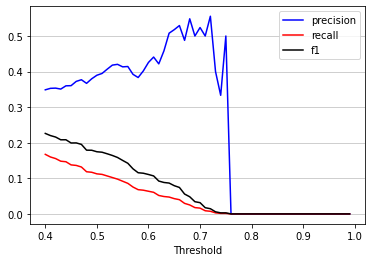

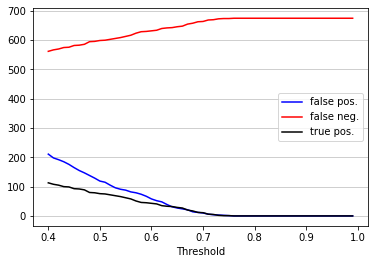

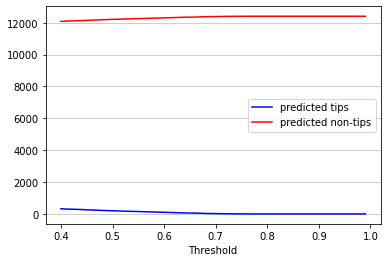

In [ ]:
# Precision vs. Recall
plt.plot(thresholds, precisions, 'blue', label='precision')
plt.plot(thresholds, recalls, 'red', label='recall')
plt.plot(thresholds, f1s, 'black', label='f1')
plt.xlabel('Threshold')
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

# False positives vs. False negatives
plt.plot(thresholds, false_pos, 'blue', label='false pos.')
plt.plot(thresholds, false_neg, 'red', label='false neg.')
plt.plot(thresholds, true_pos, 'black', label='true pos.')
plt.xlabel('Threshold')
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

# Predicted tips vs. non-tips
plt.plot(thresholds, tips_pred, 'blue', label='predicted tips')
plt.plot(thresholds, nontips_pred, 'red', label='predicted non-tips')
plt.xlabel('Threshold')
plt.grid(axis='y', alpha=0.75)
plt.legend()
#plt.hlines(y=770, xmin=0.4, xmax=0.99, linestyle='dotted', linewidth=1.0)
plt.show()

@references: 
* https://huggingface.co/transformers/custom_datasets.html